In [ ]:
!unzip "/content/VisDrone2019-DET-val.zip" -d "/content/dataset"

Archive:  /content/VisDrone2019-DET-val.zip
   creating: /content/dataset/VisDrone2019-DET-val/
  inflating: /content/dataset/VisDrone2019-DET-val/.DS_Store  
   creating: /content/dataset/VisDrone2019-DET-val/annotations/
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_02999_d_0000005.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_03499_d_0000006.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_03999_d_0000007.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_04527_d_0000008.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05249_d_0000009.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05499_d_0000010.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_05999_d_0000011.txt  
  inflating: /content/dataset/VisDrone2019-DET-val/annotations/0000001_07999_d_0000012.txt  
  inflating: /content/dataset/Vis

In [ ]:
import os
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import time
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import structural_similarity as ssim

In [ ]:
def load_img(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def parse_annotations(img_path):
    label_path = img_path.replace('/images/', '/annotations/').replace('.jpg', '.txt')
    boxes = {}
    with open(label_path, 'r') as file:
        for line in file:
            vals = list(map(int, line.strip().split(',')))
            x, y, w, h, _, category_id, _, _ = vals
            boxes.setdefault(category_id, []).append((x, y, w, h))
    return boxes

In [ ]:
def plot_image(img, boxes=None, label='Image'):
    temp = img.copy()
    if boxes:
        for (x, y, w, h) in boxes:
            cv2.rectangle(temp, (x, y), (x+w, y+h), (255, 0, 0), 2)
    plt.imshow(temp)
    plt.title(label)
    plt.axis('off')
    plt.show()

In [ ]:
def compute_iou(b1, b2):
    x1, y1, w1, h1 = b1
    x2, y2, w2, h2 = b2
    xa = max(x1, x2)
    ya = max(y1, y2)
    xb = min(x1 + w1, x2 + w2)
    yb = min(y1 + h1, y2 + h2)

    if xa >= xb or ya >= yb:
        return 0.0

    inter = (xb - xa) * (yb - ya)
    area1 = w1 * h1
    area2 = w2 * h2
    return inter / min(area1, area2)

In [ ]:
def apply_color_matching(src, ref):
    matched = src.astype(np.float32)
    ref = ref.astype(np.float32)

    mean_src, std_src = np.mean(matched, axis=(0,1)), np.std(matched, axis=(0,1))
    mean_ref, std_ref = np.mean(ref, axis=(0,1)), np.std(ref, axis=(0,1))

    adjusted = (matched - mean_src) * (std_ref / std_src) + mean_ref
    return np.clip(adjusted, 0, 255).astype(np.uint8)

In [ ]:
def generate_sample(image_paths, target_class=4):
    bg_path = random.choice(image_paths)
    obj_path = random.choice(image_paths)

    bg_img = load_img(bg_path)
    src_img = load_img(obj_path)

    annots = parse_annotations(obj_path)
    objs = annots.get(target_class, [])

    result = bg_img.copy()
    placed_boxes = []
    corrected_patches = []

    for (x, y, w, h) in objs:
        patch = src_img[y:y+h, x:x+w]
        if patch.shape[0] == 0 or patch.shape[1] == 0:
            continue

        scale = np.random.uniform(0.8, 1.2)
        new_w, new_h = int(w * scale), int(h * scale)
        patch = cv2.resize(patch, (new_w, new_h))

        patch_corr = apply_color_matching(patch, bg_img)
        corrected_patches.append(patch_corr)

        for _ in range(10):
            px = random.randint(0, bg_img.shape[1] - new_w)
            py = random.randint(0, bg_img.shape[0] - new_h)
            box = (px, py, new_w, new_h)

            if all(compute_iou(box, b) < 0.5 for b in placed_boxes):
                center = (px + new_w // 2, py + new_h // 2)
                mask = 255 * np.ones_like(patch_corr, dtype=np.uint8)
                result = cv2.seamlessClone(patch_corr, result, mask, center, cv2.NORMAL_CLONE)
                placed_boxes.append(box)
                break

    return bg_img, src_img, corrected_patches, result, placed_boxes

In [ ]:
def visualize_result(bg_img, src_img, color_corrected_patches, final_img, placed_boxes):
    fig, axs = plt.subplots(2, 2, figsize=(16, 12))

    axs[0, 0].imshow(bg_img)
    axs[0, 0].set_title("Original Background")
    axs[0, 0].axis("off")

    axs[0, 1].imshow(src_img)
    axs[0, 1].set_title("Source Image with Objects")
    axs[0, 1].axis("off")

    if color_corrected_patches:
        patch = color_corrected_patches[0]
        axs[1, 0].imshow(patch)
        axs[1, 0].set_title("Example Color-Corrected Object")
        axs[1, 0].axis("off")
    else:
        axs[1, 0].text(0.5, 0.5, 'No patches', ha='center', va='center')
        axs[1, 0].axis("off")

    img_with_boxes = final_img.copy()
    for (x, y, w, h) in placed_boxes:
        cv2.rectangle(img_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    axs[1, 1].imshow(img_with_boxes)
    axs[1, 1].set_title(f"Final Image: {len(placed_boxes)} objects")
    axs[1, 1].axis("off")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.title("Histogram of Final Image")
    for i, col in enumerate(['r', 'g', 'b']):
        hist = cv2.calcHist([final_img], [i], None, [256], [0, 256])
        plt.plot(hist, color=col)
    plt.grid(True)
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [ ]:
def uniform_noise(img, low=-50, high=50):
    noise = np.random.uniform(low, high, img.shape).astype(np.float32)
    noisy = img.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(img.dtype)

def gaussian_noise(img, mean=0, std=50):
    noise = np.random.normal(mean, std, img.shape).astype(np.float32)
    noisy = img.astype(np.float32) + noise
    return np.clip(noisy, 0, 255).astype(img.dtype)

In [ ]:
class DenoisingDataset(Dataset):
    labels = {
        0: "ignored regions", 1: "pedestrian", 2: "people", 3: "bicycle",
        4: "car", 5: "van", 6: "truck", 7: "tricycle",
        8: "awning-tricycle", 9: "bus", 10: "motor", 11: "others"
    }

    def __init__(self, dataset_path, size, label, noise_type='gaussian', noise_params={}):
        self.size = size
        self.image_paths = []
        img_dir = os.path.join(dataset_path, 'images')
        for f in os.scandir(img_dir):
            if f.name.endswith('.jpg'):
                self.image_paths.append(f.path)

        if noise_type == 'gaussian':
            self.add_noise = lambda img: gaussian_noise(img, **noise_params)
        elif noise_type == 'uniform':
            self.add_noise = lambda img: uniform_noise(img, **noise_params)
        else:
            self.add_noise = lambda img: img

        self.target_label = label
        print(f"Dataset initialized with target label: {self.labels.get(label, 'Unknown')}")

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        _, _, _, original_img, _ = generate_sample(self.image_paths, self.target_label)
        noisy_img = self.add_noise(original_img)
        return original_img, noisy_img

In [ ]:
def custom_median_filter(image, kernel_size=5):
    img_padded = np.pad(image, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2), (0,0)), mode='reflect')
    output = np.zeros_like(image)
    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                output[i, j, c] = np.median(img_padded[i:i+kernel_size, j:j+kernel_size, c])
    return output.astype(image.dtype)


def custom_gaussian_filter(image, kernel_size=5, sigma=1.0):
    def gaussian_kernel(size, sigma):
        kernel = np.fromfunction(
            lambda x, y: (1/(2*np.pi*sigma**2)) * np.exp(-((x-(size-1)/2)**2 + (y-(size-1)/2)**2)/(2*sigma**2)),
            (size, size)
        )
        return kernel / np.sum(kernel)

    kernel = gaussian_kernel(kernel_size, sigma)
    output = np.zeros_like(image, dtype=np.float32)
    img_padded = np.pad(image, ((kernel_size//2, kernel_size//2), (kernel_size//2, kernel_size//2), (0,0)), mode='reflect').astype(np.float32)

    for c in range(image.shape[2]):
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                output[i, j, c] = np.sum(img_padded[i:i+kernel_size, j:j+kernel_size, c] * kernel)
    return np.clip(output, 0, 255).astype(image.dtype)

In [ ]:
def estimate_denoising(filter_func, orig, noisy):
    start = time.time()
    filtered = filter_func(noisy)
    elapsed = (time.time() - start)
    if orig.dtype != filtered.dtype:
        filtered = filtered.astype(orig.dtype)

    current_mse = mse(orig, filtered)
    current_ssim = ssim(orig, filtered, channel_axis=-1, data_range=255)

    return {'Time': elapsed, 'MSE': current_mse, 'SSIM': current_ssim}

Dataset initialized with target label: car
Dataset initialized with target label: pedestrian

--- Denoising Evaluation for GAUSSIAN NOISE ---

Image 1 (Gaussian Noise):


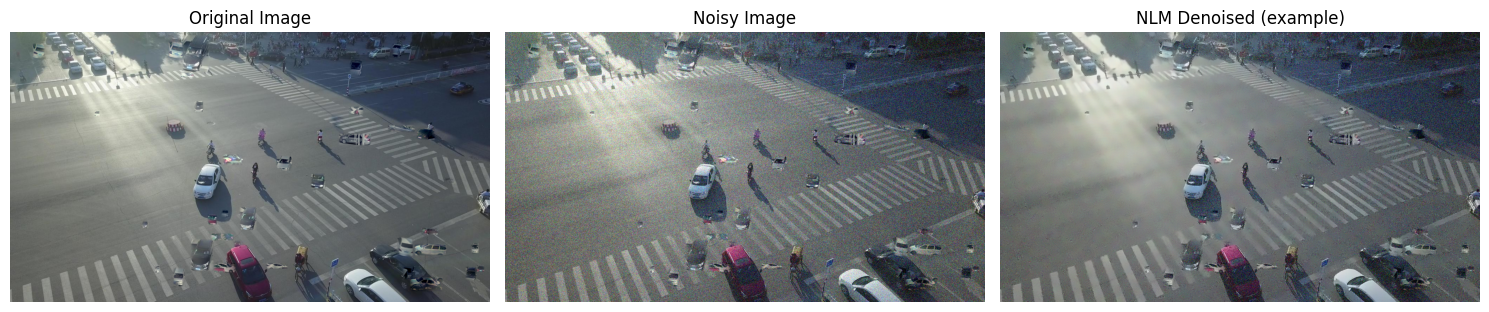

--- Metrics ---
  Median (cv2):
    Time: 0.0073
    MSE: 106.1763
    SSIM: 0.6098
  Gauss (cv2):
    Time: 0.0045
    MSE: 98.5961
    SSIM: 0.5913
  Bilateral (cv2):
    Time: 0.3015
    MSE: 120.1299
    SSIM: 0.5146
  NLM (cv2):
    Time: 5.5009
    MSE: 264.2306
    SSIM: 0.5369
  Custom Median (CPU):
    Time: 59.5805
    MSE: 106.1165
    SSIM: 0.6098
  Custom Gauss (CPU):
    Time: 23.2421
    MSE: 98.9387
    SSIM: 0.5926

--- Denoising Evaluation for UNIFORM NOISE ---

Image 1 (Uniform Noise):


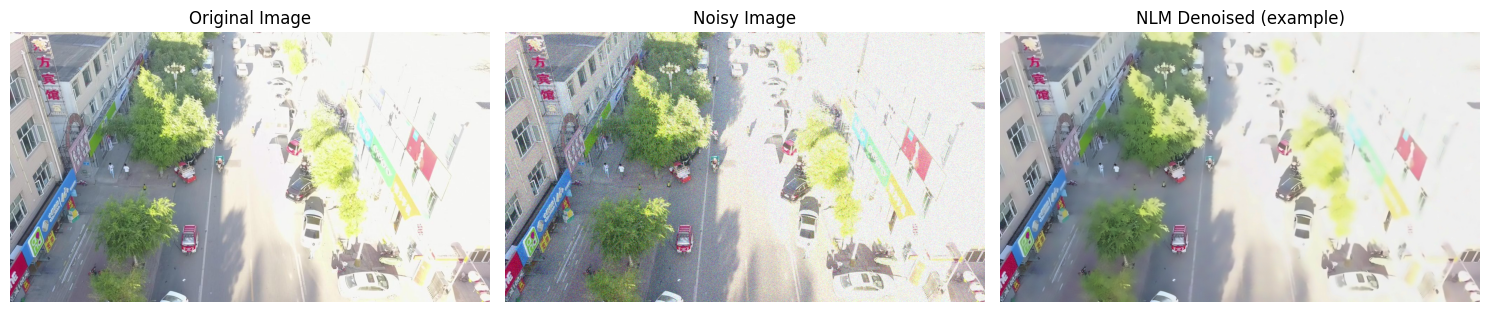

--- Metrics ---
  Median (cv2):
    Time: 0.0064
    MSE: 157.8332
    SSIM: 0.5962
  Gauss (cv2):
    Time: 0.0034
    MSE: 105.3989
    SSIM: 0.7259
  Bilateral (cv2):
    Time: 0.1467
    MSE: 80.1233
    SSIM: 0.7719
  NLM (cv2):
    Time: 3.1022
    MSE: 99.7545
    SSIM: 0.8122
  Custom Median (CPU):
    Time: 53.4300
    MSE: 158.1134
    SSIM: 0.5962
  Custom Gauss (CPU):
    Time: 24.1560
    MSE: 108.4404
    SSIM: 0.7263


In [ ]:
dataset_dir = '/content/dataset/VisDrone2019-DET-val'


denoising_dataset_gaussian = DenoisingDataset(dataset_path=dataset_dir, size=1, label=4,noise_type='gaussian', noise_params={'mean': 0, 'std': 30})
denoising_loader_gaussian = DataLoader(denoising_dataset_gaussian, batch_size=1)

denoising_dataset_uniform = DenoisingDataset(dataset_path=dataset_dir, size=1, label=1,noise_type='uniform', noise_params={'low': -40, 'high': 40})
denoising_loader_uniform = DataLoader(denoising_dataset_uniform, batch_size=1)

filters = {
    'Median (cv2)': (lambda x : cv2.medianBlur(x, 5)),
    'Gauss (cv2)': (lambda x : cv2.GaussianBlur(x, (5, 5), 1.0)),
    'Bilateral (cv2)': (lambda x : cv2.bilateralFilter(x, 9, 75, 75)),
    'NLM (cv2)': (lambda x : cv2.fastNlMeansDenoisingColored(x, None, 10, 10, 7, 21)),
    'Custom Median (CPU)': (lambda x: custom_median_filter(x, kernel_size=5)),
    'Custom Gauss (CPU)': (lambda x: custom_gaussian_filter(x, kernel_size=5, sigma=1.0)),
}

print("\nDenoising Evaluation for GAUSSIAN NOISE")
for i, (orig_img, noisy_img) in enumerate(denoising_loader_gaussian):
    orig_img = orig_img[0].numpy().astype(np.uint8)
    noisy_img = noisy_img[0].numpy().astype(np.uint8)

    print(f"\nImage {i+1} (Gaussian Noise):")
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_img)
    plt.title("Noisy Image")
    plt.axis('off')

    denoised_images = {}
    metrics_results = {}

    for name, filter_func in filters.items():
        result = estimate_denoising(filter_func, orig_img, noisy_img)
        denoised_images[name] = filter_func(noisy_img)
        metrics_results[name] = result

    plt.subplot(1, 3, 3)
    if 'NLM (cv2)' in denoised_images:
        plt.imshow(denoised_images['NLM (cv2)'])
        plt.title("NLM Denoised (example)")
    elif 'Median (cv2)' in denoised_images:
          plt.imshow(denoised_images['Median (cv2)'])
          plt.title("Median Denoised (example)")
    else:
        plt.text(0.5, 0.5, 'No filtered image to display', ha='center', va='center')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("Metrics")
    for name, metrics in metrics_results.items():
        print(f"  {name}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")

print("\nDenoising Evaluation for UNIFORM NOISE")
for i, (orig_img, noisy_img) in enumerate(denoising_loader_uniform):
    orig_img = orig_img[0].numpy().astype(np.uint8)
    noisy_img = noisy_img[0].numpy().astype(np.uint8)

    print(f"\nImage {i+1} (Uniform Noise):")
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.imshow(orig_img)
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(noisy_img)
    plt.title("Noisy Image")
    plt.axis('off')

    denoised_images = {}
    metrics_results = {}

    for name, filter_func in filters.items():
        result = estimate_denoising(filter_func, orig_img, noisy_img)
        denoised_images[name] = filter_func(noisy_img)
        metrics_results[name] = result

    plt.subplot(1, 3, 3)
    if 'NLM (cv2)' in denoised_images:
        plt.imshow(denoised_images['NLM (cv2)'])
        plt.title("NLM Denoised (example)")
    elif 'Median (cv2)' in denoised_images:
          plt.imshow(denoised_images['Median (cv2)'])
          plt.title("Median Denoised (example)")
    else:
        plt.text(0.5, 0.5, 'No filtered image to display', ha='center', va='center')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("Metrics")
    for name, metrics in metrics_results.items():
        print(f"  {name}:")
        for metric, value in metrics.items():
            print(f"    {metric}: {value:.4f}")